<a href="https://colab.research.google.com/github/AndrewDrury/FakeNewsML/blob/main/MSCI446_FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSCI Project - Fake News
Written by Andrew Drury & Michael Cheng

### Imports
All imports required for the project.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Part 1: Data Transformation

### Load data from tsv file
The tsv file contains 12,386 rows each containing a statement that has been fact checked with additional descriptive columns. A github repository was created in order to store the tsv file. The data is imported and assigned column names.

In [3]:
# Link to the raw tsv file stored in a Github repository
datasetUrl = 'https://raw.githubusercontent.com/AndrewDrury/FakeNewsML/main/factCheck.tsv'

# Load tsv file, assign column names to tsv
df = pd.read_csv(datasetUrl, delimiter='\t', engine='python', header=None, names=['id', 'label', 'statement', 'subjects', 'speaker', 'job-title', 'state', 'party-affiliation', 'barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'context'])

### Create TF-IDF Matrix for Statements
To predict the truthfulness of a statement, the words in the statement need to be extrated and transformed into a useful form of input. A TF-IDF (term frequency inverse document frequency matrix) of stems will be created from the words in the statement.

In order to create the TF-IDF matrix of stems, the following text mining methods will be applied to each statement:

1.   All characters in the statement will be transformed to lowercase
2.   Statements will be split into tokens, each token representing a continuous sequence of alphanumerics
3.   All non-alphanumeric characters will be removed
4.   Remove common stopwords that do not provide any useful information (words like 'the', 'a')
5.   The SnowballStemmer package will be used to transform tokens into stems. SnowballStemmer is chosen over its commonly used predecessor, PorterStemmer, as it applies more agressive stemming and corrects common issues found in PorterStemmer. Stems are the roots of a word and will reduce the number of features (tokens). Many similar tokens will be reduced to their singular and common root. For example, the words 'likes', 'liked', 'liking', and 'likely' will all be reduced to their stem 'like'.

A TF-IDF 2D matrix will be created from the stems created in step 4 using SKLearn's TfidfVectorizer. Each row in the matrix created will represent a statement, and the columns in the matrix will represent the stems. The TF-IDF score is computed by multiplying the stem or term frequency TF in the statement by the inverse document frequency IDF. The inverse document frequency is calculated by dividing the total number of statements by the number of documents that contain the given stem. The TF-IDF score is commonly used with textual data as it augments unique and relevant terms in a body of text such as a statement.





In [4]:
def tfidfMatrix(column):
  # Transform all characters to lowercase
  lowerCase = column.str.lower()

  # Tokenize strings
  tokens = lowerCase.apply(word_tokenize)

  # Remove all non-alphanumeric characters
  alphanumerics= tokens.apply(lambda statement: [re.sub(r'[\W_]+', '', token) for token in statement])

  # Remove common stopwords that do not provide any useful information (words like 'the', 'a')
  stopList = stopwords.words('english')
  tokensNoStopWords= alphanumerics.apply(lambda statement: [token for token in statement if token not in (stopList)])

  # Stem tokens in strings using SnowballStemmer
  stemmer = SnowballStemmer("english")
  stems = tokensNoStopWords.apply(lambda x: [stemmer.stem(y) for y in x])

  # Stems need to reform into sentences split with a space ' ' to use the TF-IDF vectorizer
  stemSentences = stems.apply(lambda x: ' '.join(x))

  # Create TF-IDF Matrix of stems
  tfidfVectorizer = TfidfVectorizer()
  tfidfFinal = tfidfVectorizer.fit_transform(stemSentences)

  # tfidf.vocabulary_ returns all unique terms in the tfidf matrix with their index
  print(tfidfVectorizer.vocabulary_)
  print('There are %s unique stems (columns) in the statement tfidf matrix.'% len(tfidfVectorizer.vocabulary_))

  return tfidfFinal

statements = tfidfMatrix(df['statement'])


{'say': 8109, 'anni': 1381, 'list': 5722, 'polit': 7222, 'group': 4492, 'support': 8974, 'thirdtrimest': 9250, 'abort': 1079, 'demand': 3088, 'declin': 3035, 'coal': 2522, 'start': 8754, 'natur': 6403, 'gas': 4256, 'took': 9347, 'begin': 1763, 'presid': 7343, 'georg': 4304, 'bush': 2123, 'administr': 1153, 'hillari': 4756, 'clinton': 2497, 'agre': 1212, 'john': 5296, 'mccain': 5998, 'vote': 9864, 'give': 4340, 'benefit': 1793, 'doubt': 3372, 'iran': 5166, 'health': 4658, 'care': 2229, 'reform': 7700, 'legisl': 5624, 'like': 5696, 'mandat': 5891, 'free': 4149, 'sex': 8328, 'chang': 2356, 'surgeri': 8987, 'econom': 3490, 'turnaround': 9507, 'end': 3600, 'term': 9158, 'chicago': 2401, 'bear': 1742, 'quarterback': 7521, 'last': 5553, '10': 15, 'year': 10182, 'total': 9369, 'number': 6598, 'tenur': 9157, 'uw': 9750, 'faculti': 3817, 'fire': 3972, 'two': 9532, 'decad': 3020, 'jim': 5281, 'dunnam': 3450, 'live': 5731, 'district': 3295, 'repres': 7778, 'person': 7081, 'stage': 8730, 'work': 10

### Create TF Matrix for Subjects

A TF Matrix is created for the subjects column. There are 144 columns (subjects) in the TF matrix. Minimal textual preprocessing is needed for the subjects as they have already been processed.

In [12]:
# Transform all subjects to lowercase
def preprocessorSubjects(subjects):
    return(subjects.lower())

# Tokenize the subjects, splitting by comma
def tokenizerSubjects(subjects):
    tokens = subjects.split(',')
    return(tokens)

# Create TF Matrix for Subjects using CountVectorizer
def subjectTfMatrix(column):
  subjectVectorizer = CountVectorizer(preprocessor=preprocessorSubjects, tokenizer=tokenizerSubjects)
  subjects = subjectVectorizer.fit_transform(column)
  return subjects, subjectVectorizer

origSubjects = df['subjects']
subjects, subjectVectorizer = subjectTfMatrix(origSubjects)
# print('All Subjects: ', subjectVectorizer.get_feature_names_out())
print('Num of Subjects: ', len(subjectVectorizer.get_feature_names_out()))
# print(subjects.toarray())

Num of Subjects:  144


### Create TF Matrix for Contexts

A TF Matrix is created for the contexts column. There are 2104 columns (contextual terms) in the TF matrix. Similar to the statements, heavy textual preprocessing is needed for the contexts including transforming to lowercase, removing stop words keeping only characters present in the alphabet, and stemming using SnowballStemmer.

In [9]:
# Clean contexts
def preprocessorContexts(contexts):
  # Transform all characters to lowercase
  lowerCase = contexts.lower()
  # print(lowerCase)

  # Tokenize strings
  tokens = word_tokenize(lowerCase)

  # Keep only letters in the alphabet and remove common stopwords
  stopList = stopwords.words('english')
  cleanesedTokens = [re.sub(r'[^a-z]', ' ', token) for token in tokens if token not in (stopList)]

  # Stem tokens in strings using SnowballStemmer
  stemmer = SnowballStemmer("english")
  stems = [stemmer.stem(token) for token in cleanesedTokens if len(token) > 1]

  # Stems need to reform into sentences split with a space ' ' to use the CountVectorizer
  stemContexts = ' '.join(stems)
  return(stemContexts)

# Tokenize the contexts
def tokenizerContexts(contexts):
    # print(contexts)
    tokens = [token for token in contexts.split(' ') if len(token) > 1]
    return(tokens)

# Create TF Matrix for contexts using CountVectorizer
def contextTfMatrix(column):
  contextVectorizer = CountVectorizer(preprocessor=preprocessorContexts, tokenizer=tokenizerContexts)
  contexts = contextVectorizer.fit_transform(column.apply(lambda x: np.str_(x)))
  return contexts, contextVectorizer

origContext = df['context']
contexts, contextVectorizer = contextTfMatrix(origContext)
# print('All Contexts: ', contextVectorizer.get_feature_names_out())
print('Num of Contexts: ', len(contextVectorizer.get_feature_names_out()))
# print(contexts.toarray())

Num of Contexts:  2104


### Store x and y

In [15]:
# Combine statements TF-IDF, subjects TF, and contexts TF matrices in one x matrices
x = []
for index in range(statements.shape[0]):
  newRow = statements[index].toarray()
  newRow = np.append(newRow, subjects[index].toarray())
  newRow = np.append(newRow, contexts[index].toarray())
  x.append(newRow)

# Store class labels in y
y = df['label']

## Part 2: Data Description

Mean:  2139.3333333333335
Median:  2287.0
--------------------
 true           2063
mostly-true    2466
half-true      2638
barely-true    2108
false          2511
pants-fire     1050
Name: label, dtype: int64


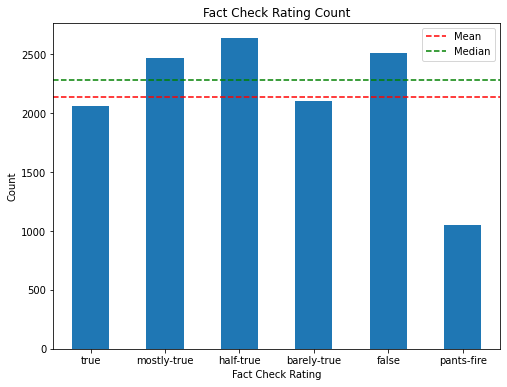

In [29]:
# Create bar chart for fact check label counts
labelCounts = y.value_counts()
labelCounts = labelCounts.reindex(['true','mostly-true','half-true','barely-true','false','pants-fire'])
labelCountPlot = labelCounts.plot(kind='bar', rot=0, title='Fact Check Rating Count', label='_nolegend_', figsize=(8,6))
# labelCountPlot.bar_label(labelCountPlot.containers[0])

labelCountPlot.set_xlabel('Fact Check Rating')
labelCountPlot.set_ylabel('Count')

mean = labelCounts.mean()
median = labelCounts.median()
labelCountPlot.axhline(mean, color='r', ls='--', label="Mean")
labelCountPlot.axhline(median, color='g', ls='--', label="Median")
labelCountPlot.legend()
print('Mean: ', mean)
print('Median: ', median)
print('-'*20+'\n', labelCounts)




## Part 3: Supervised Learning - Classification

** TO REMOVE **
If classification model performance sucks, you may want to try encoding the y variable class labels, potentialy an ordered numerical enconding since the labels are ordered themeselves from pants-on-fire fake to completely true

Another option if performance sucks would be to group the y variables class labels into 2 groups instead of the 6 ('true','mostly-true','half-true','barely-true','false','pants-fire'). So 'true' and 'mostly-true' become 'true' and everything else becomes 'false'

In [31]:
folds = 5

x_supervised = np.asarray(x)
y_supervised = y.copy()

metrics = []

# SPLIT DATASET 80-20 TRAIN/TEST with Stratified kfold validation using 5 folds
# Stratified kfold preserves the same proportions of each class in the split
kIndices = StratifiedKFold(n_splits=folds)
for trainIndice, testIndice in kIndices.split(x_supervised, y_supervised):
  train_x, test_x = x_supervised[trainIndice], x_supervised[testIndice]
  train_y, test_y = y_supervised[trainIndice], y_supervised[testIndice]

  # Train classification model with train_x and train_y
  # Test model with test_x and test_y
  # Compute metrics for model for current kfold

# Calculate metric averages across the 5 kfolds


## Part 4: Unsupervised Learning - Association Rule Mining

In [32]:
folds = 5

x_unsupervised = np.asarray(x)
y_unsupervised = y.copy()

metrics = []

# SPLIT DATASET 80-20 TRAIN/TEST with Stratified kfold validation using 5 folds
# Stratified kfold preserves the same proportions of each class in the split
kIndices = StratifiedKFold(n_splits=folds)
for trainIndice, testIndice in kIndices.split(x_unsupervised, y_unsupervised):
  train_x, test_x = x_unsupervised[trainIndice], x_unsupervised[testIndice]
  train_y, test_y = y_unsupervised[trainIndice], y_unsupervised[testIndice]

  # Train classification model with train_x and train_y
  # Test model with test_x and test_y
  # Compute metrics for model for current kfold

# Calculate metric averages across the 5 kfolds